In [1]:
from models.GCN import GCN
from models.GAT import GATFLAT
from help_funcs.data_func import load_dataset
from help_funcs.param import get_loss_function
import yaml
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [2]:
def make_interference(data, model, loss_name, loss_func):
    val_loss = 0
    all_predictions = []
    all_labels = []
    y_score = []
    for batch in data:
        x, edge_index, edge_weight, structure = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        y_hat = model.forward(x, edge_index, edge_weight, structure)
        
        if loss_name != 'BCE':
            y_score += y_hat.exp().tolist()
        else:
            y_score += y_hat.tolist()
            
        y = batch.y
        if loss_name == 'BCE':
            y = y.float()
            y_hat = y_hat.squeeze(1)
        y = y

        loss = loss_func(y_hat, y)
        val_loss += loss

        if loss_name == 'BCE':
            all_predictions += y_hat.round().tolist()
        else:
            all_predictions += torch.argmax(y_hat, dim=-1).tolist()
        all_labels += batch.y.tolist()

    return val_loss/len(data), f1_score(all_labels, all_predictions, average='micro'), y_score, all_labels

In [3]:
def plot_ruc(roc_curve_data, num_of_classes):
    # Define class labels and split names
    split_names = ['train', 'val', 'test']
    colors = {0:'red', 1:'green', 2:'orange', 3:'blue'}

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))  # One subplot per split
    if num_of_classes == 4:
        class_labels_legends = {0:'TD', 1:'ASD-ADHD', 2:'ASD', 3:'ADHD'}
    else: 
        class_labels_legends = {0:'TD', 1:'Non-TD'}

    for ax, split_name in zip(axes, split_names):
        y_true = np.array(roc_curve_data[split_name][0])
        y_probs = np.array(roc_curve_data[split_name][1])
        
        y_true_bin = label_binarize(y_true, classes=np.arange(num_of_classes))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_of_classes if num_of_classes != 2 else 1):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                    label=f'{class_labels_legends[i]} (AUC = {roc_auc[i]:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{split_name.capitalize()} ROC Curve')
        ax.legend(loc='lower right')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# GCN Multi-class

### Hyperparameters

In [4]:
with open("saved_models/GCN_Multi_absolute_weights.yaml", 'r') as file:
    gcn_multi = yaml.safe_load(file)

### Load data

In [5]:
train_data = load_dataset(dataset = 'train', 
                        num_of_classes = gcn_multi['num_of_classes']['value'],
                        feature_names = gcn_multi['feature_names']['value'],
                        edge_names = gcn_multi['edge_names']['value'],
                        edge_w_thres = gcn_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_multi['edge_w_abs']['value'],
                        GAT = False
                                )
val_data = load_dataset(dataset = 'val', 
                        num_of_classes = gcn_multi['num_of_classes']['value'],
                        feature_names = gcn_multi['feature_names']['value'],
                        edge_names = gcn_multi['edge_names']['value'],
                        edge_w_thres = gcn_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_multi['edge_w_abs']['value'],
                        GAT = False
                                )
test_data = load_dataset(dataset = 'test', 
                        num_of_classes = gcn_multi['num_of_classes']['value'],
                        feature_names = gcn_multi['feature_names']['value'],
                        edge_names = gcn_multi['edge_names']['value'],
                        edge_w_thres = gcn_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_multi['edge_w_abs']['value'],
                        GAT = False
                                )

train_loader = DataLoader(train_data, 
                          batch_size=gcn_multi['batch_size']['value'])
                            
val_loader = DataLoader(val_data, 
                         batch_size=gcn_multi['batch_size']['value'])

test_loader = DataLoader(test_data, 
                         batch_size=gcn_multi['batch_size']['value'])

### Load model + parameters

train loss: 0.9906559586524963 f1:0.5782312925170068
val loss: 1.040687918663025 f1:0.4444444444444444
test loss: 1.299743890762329 f1:0.42857142857142855


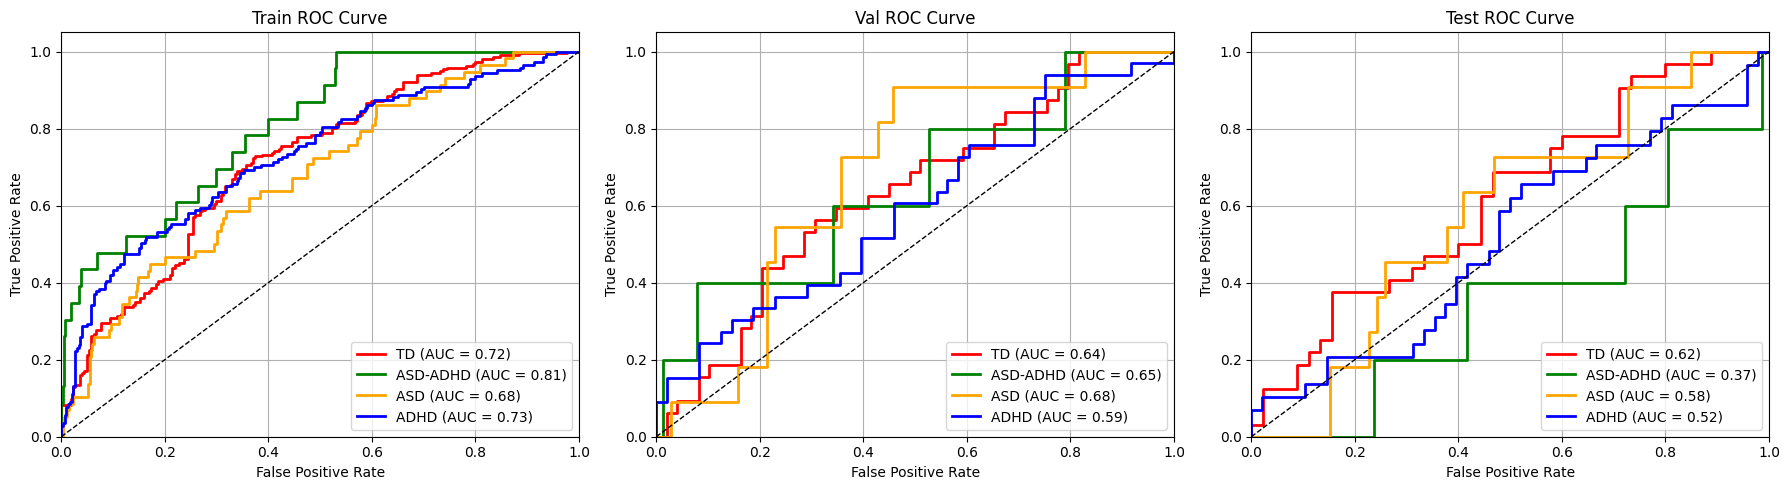

In [6]:
gcn_multi_model = GCN(in_ = gcn_multi['num_of_features']['value'], 
                      out_ = gcn_multi['num_of_classes']['value'], 
                      layer_1_out = gcn_multi['hidden_channels_1']['value'], 
                      dropout_rate = gcn_multi['dropout']['value'], 
                      activation_ = gcn_multi['activation']['value'], 
                      pool_ = gcn_multi['pool']['value'], 
                      norm_ = gcn_multi['layer_norm']['value'], 
                      out_func_ = gcn_multi['loss_name']['value'], 
                      random_seed = gcn_multi['random_seed']['value'])
gcn_multi_model.load_state_dict(torch.load("saved_models/GCN_Multi_absolute_weights_434.pt", weights_only=True, map_location=torch.device('cpu')))
gcn_multi_model.eval()
loss_func = get_loss_function(gcn_multi['loss_name']['value'])

roc_curve_data = {}
for n, d in [('train', train_loader),('val', val_loader), ('test', test_loader)]:
    l, f1, y_score, y = make_interference(data = d,
                                            model = gcn_multi_model, 
                                            loss_name = gcn_multi['loss_name']['value'], 
                                            loss_func = loss_func)
    print(f"{n} loss: {l} f1:{f1}")
    roc_curve_data[n] = [y, y_score]

plot_ruc(roc_curve_data, num_of_classes = 4)

# GCN Binary-class

### Hyperparameters

In [7]:
with open("saved_models/GCN_Binary_absolute_weights.yaml", 'r') as file:
    gcn_binary = yaml.safe_load(file)

In [8]:
train_data = load_dataset(dataset = 'train', 
                        num_of_classes = gcn_binary['num_of_classes']['value'],
                        feature_names = gcn_binary['feature_names']['value'],
                        edge_names = gcn_binary['edge_names']['value'],
                        edge_w_thres = gcn_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_binary['edge_w_abs']['value'],
                        GAT = False
                                )
val_data = load_dataset(dataset = 'val', 
                        num_of_classes = gcn_binary['num_of_classes']['value'],
                        feature_names = gcn_binary['feature_names']['value'],
                        edge_names = gcn_binary['edge_names']['value'],
                        edge_w_thres = gcn_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_binary['edge_w_abs']['value'],
                        GAT = False
                                )
test_data = load_dataset(dataset = 'test', 
                        num_of_classes = gcn_binary['num_of_classes']['value'],
                        feature_names = gcn_binary['feature_names']['value'],
                        edge_names = gcn_binary['edge_names']['value'],
                        edge_w_thres = gcn_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gcn_binary['edge_w_abs']['value'],
                        GAT = False
                                )

train_loader = DataLoader(train_data, 
                          batch_size=gcn_binary['batch_size']['value'])
                            
val_loader = DataLoader(val_data, 
                         batch_size=gcn_binary['batch_size']['value'])

test_loader = DataLoader(test_data, 
                         batch_size=gcn_binary['batch_size']['value'])

train loss: 0.5626474618911743 f1:0.6938775510204082
val loss: 0.6043192744255066 f1:0.654320987654321
test loss: 0.7038617134094238 f1:0.6103896103896104


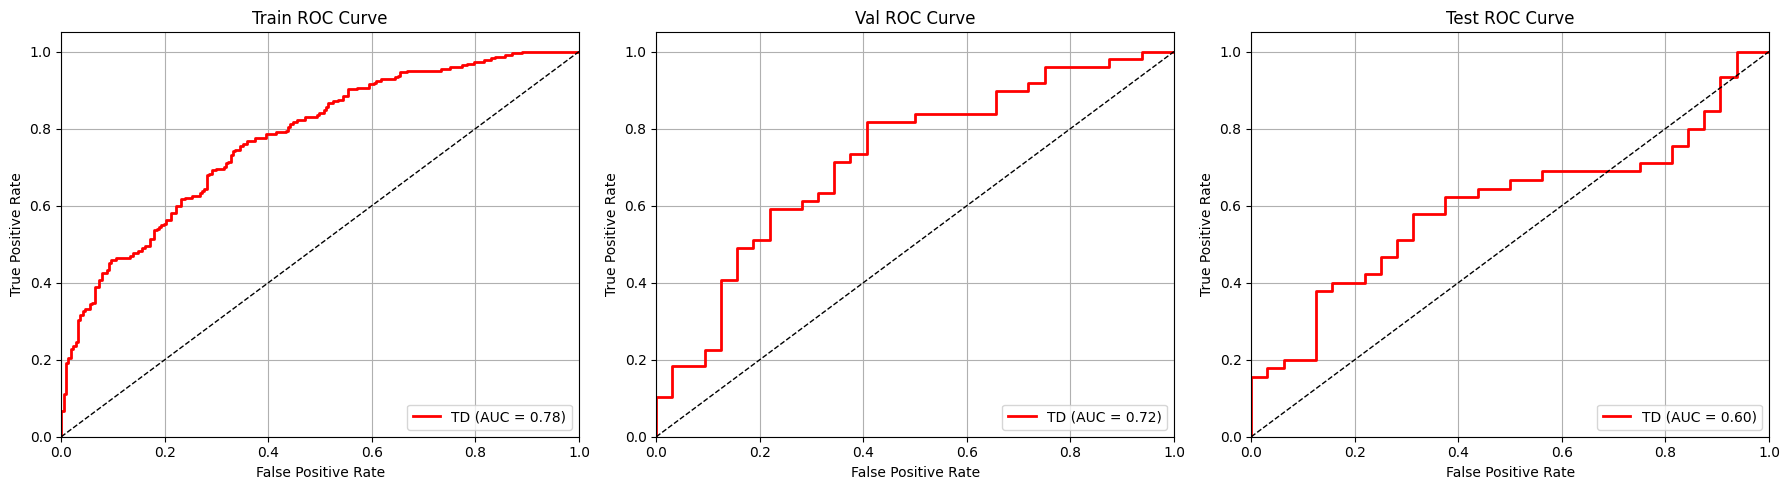

In [9]:
gcn_binary_model = GCN(in_ = gcn_binary['num_of_features']['value'], 
                      out_ = gcn_binary['num_of_classes']['value']-1, 
                      layer_1_out = gcn_binary['hidden_channels_1']['value'], 
                      dropout_rate = gcn_binary['dropout']['value'], 
                      activation_ = gcn_binary['activation']['value'], 
                      pool_ = gcn_binary['pool']['value'], 
                      norm_ = gcn_binary['layer_norm']['value'], 
                      out_func_ = gcn_binary['loss_name']['value'], 
                      random_seed = gcn_binary['random_seed']['value'])
gcn_binary_model.load_state_dict(torch.load("saved_models/GCN_Binary_absolute_weights_301.pt", weights_only=True, map_location=torch.device('cpu')))
gcn_binary_model.eval()
loss_func = get_loss_function(gcn_binary['loss_name']['value'])

roc_curve_data = {}
for n, d in [('train', train_loader),('val', val_loader), ('test', test_loader)]:
    l, f1, y_score, y = make_interference(data = d,
                                            model = gcn_binary_model, 
                                            loss_name = gcn_binary['loss_name']['value'], 
                                            loss_func = loss_func)
    print(f"{n} loss: {l} f1:{f1}")
    roc_curve_data[n] = [y, y_score]

plot_ruc(roc_curve_data, num_of_classes = 2)


# GAT Multi-class

In [10]:
with open("saved_models/GAT_Multi_absolute_value_and_threshold.yaml", 'r') as file:
    gat_multi = yaml.safe_load(file)
    
train_data = load_dataset(dataset = 'train', 
                        num_of_classes = gat_multi['num_of_classes']['value'],
                        feature_names = gat_multi['feature_names']['value'],
                        edge_names = gat_multi['edge_names']['value'],
                        edge_w_thres = gat_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_multi['edge_w_abs']['value'],
                        GAT = True
                                )
val_data = load_dataset(dataset = 'val', 
                        num_of_classes = gat_multi['num_of_classes']['value'],
                        feature_names = gat_multi['feature_names']['value'],
                        edge_names = gat_multi['edge_names']['value'],
                        edge_w_thres = gat_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_multi['edge_w_abs']['value'],
                        GAT = True
                                )
test_data = load_dataset(dataset = 'test', 
                        num_of_classes = gat_multi['num_of_classes']['value'],
                        feature_names = gat_multi['feature_names']['value'],
                        edge_names = gat_multi['edge_names']['value'],
                        edge_w_thres = gat_multi['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_multi['edge_w_abs']['value'],
                        GAT = True
                                )

train_loader = DataLoader(train_data, 
                          batch_size=gat_multi['batch_size']['value'])
                            
val_loader = DataLoader(val_data, 
                         batch_size=gat_multi['batch_size']['value'])

test_loader = DataLoader(test_data, 
                         batch_size=gat_multi['batch_size']['value'])

concat:True, norm_dim: 128
concat:True, norm_dim: 128
train loss: 0.9142971634864807 f1:0.5782312925170068
val loss: 0.9799020886421204 f1:0.5679012345679012
test loss: 1.43928062915802 f1:0.37662337662337664


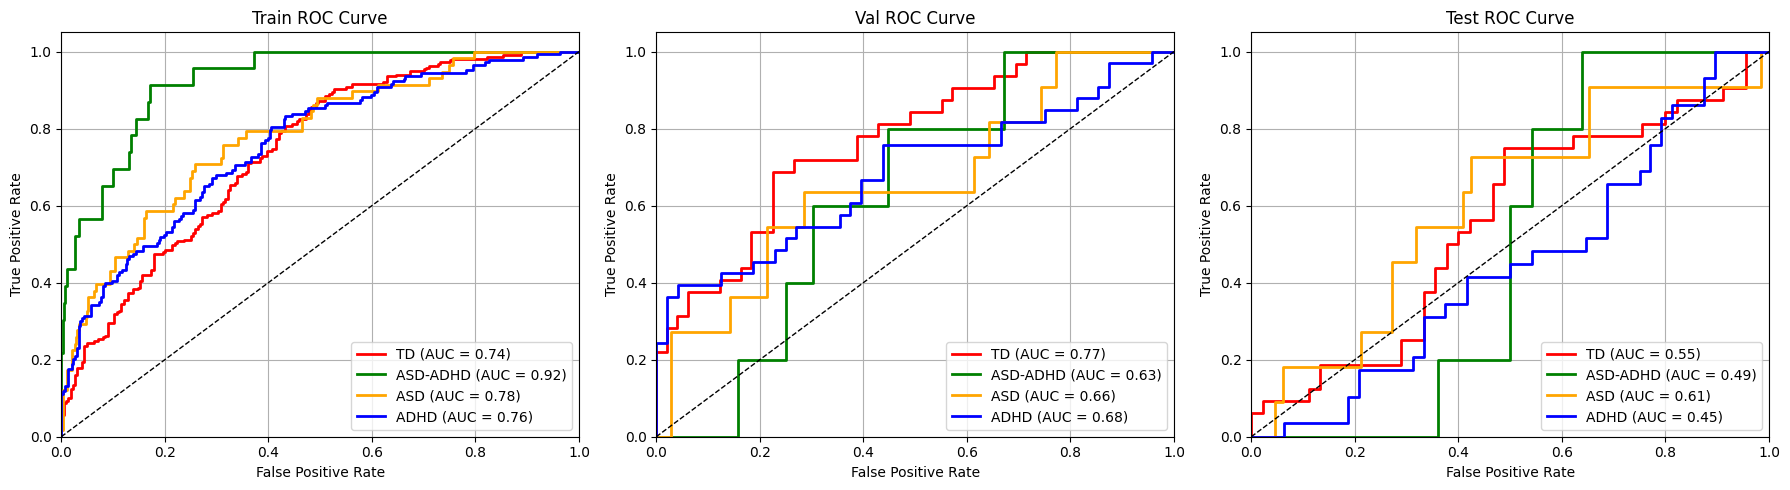

In [11]:
gat_multi_model = GATFLAT(in_ = gat_multi['num_of_features']['value'], 
                            out_ = gat_multi['num_of_classes']['value'], 
                            layer_1_out = gat_multi['hidden_channels_1']['value'], 
                            dropout_rate = gat_multi['dropout']['value'], 
                            activation_ = gat_multi['activation']['value'], 
                            heads_ = gat_multi['att_heads']['value'], 
                            norm_ = gat_multi['layer_norm']['value'], 
                            out_func_ = gat_multi['loss_name']['value'], 
                            random_seed = gat_multi['random_seed']['value'])
                            
gat_multi_model.load_state_dict(torch.load("saved_models/GAT_Multi_absolute_value_and_threshold_329.pt", weights_only=True, map_location=torch.device('cpu')))
gat_multi_model.eval()
loss_func = get_loss_function(gat_multi['loss_name']['value'])

roc_curve_data = {}
for n, d in [('train', train_loader),('val', val_loader), ('test', test_loader)]:
    l, f1, y_score, y = make_interference(data = d,
                                            model = gat_multi_model, 
                                            loss_name = gat_multi['loss_name']['value'], 
                                            loss_func = loss_func)
    print(f"{n} loss: {l} f1:{f1}")
    roc_curve_data[n] = [y, y_score]

plot_ruc(roc_curve_data, num_of_classes = 4)

# GAT Binary

In [12]:
with open("saved_models/GAT_Binary_absolute_value_and_threshold.yaml", 'r') as file:
    gat_binary = yaml.safe_load(file)
    
train_data = load_dataset(dataset = 'train', 
                        num_of_classes = gat_binary['num_of_classes']['value'],
                        feature_names = gat_binary['feature_names']['value'],
                        edge_names = gat_binary['edge_names']['value'],
                        edge_w_thres = gat_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_binary['edge_w_abs']['value'],
                        GAT = True
                                )
val_data = load_dataset(dataset = 'val', 
                        num_of_classes = gat_binary['num_of_classes']['value'],
                        feature_names = gat_binary['feature_names']['value'],
                        edge_names = gat_binary['edge_names']['value'],
                        edge_w_thres = gat_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_binary['edge_w_abs']['value'],
                        GAT = True
                                )
test_data = load_dataset(dataset = 'test', 
                        num_of_classes = gat_binary['num_of_classes']['value'],
                        feature_names = gat_binary['feature_names']['value'],
                        edge_names = gat_binary['edge_names']['value'],
                        edge_w_thres = gat_binary['edge_w_thres']['value'],
                        drop_strategy = None,
                        edge_w_abs = gat_binary['edge_w_abs']['value'],
                        GAT = True
                                )

train_loader = DataLoader(train_data, 
                          batch_size=gat_binary['batch_size']['value'])
                            
val_loader = DataLoader(val_data, 
                         batch_size=gat_binary['batch_size']['value'])

test_loader = DataLoader(test_data, 
                         batch_size=gat_binary['batch_size']['value'])

concat:True, norm_dim: 256
concat:True, norm_dim: 256
train loss: 0.5343753695487976 f1:0.7233560090702947
val loss: 0.4723256826400757 f1:0.7530864197530864
test loss: 0.7071062922477722 f1:0.5844155844155844


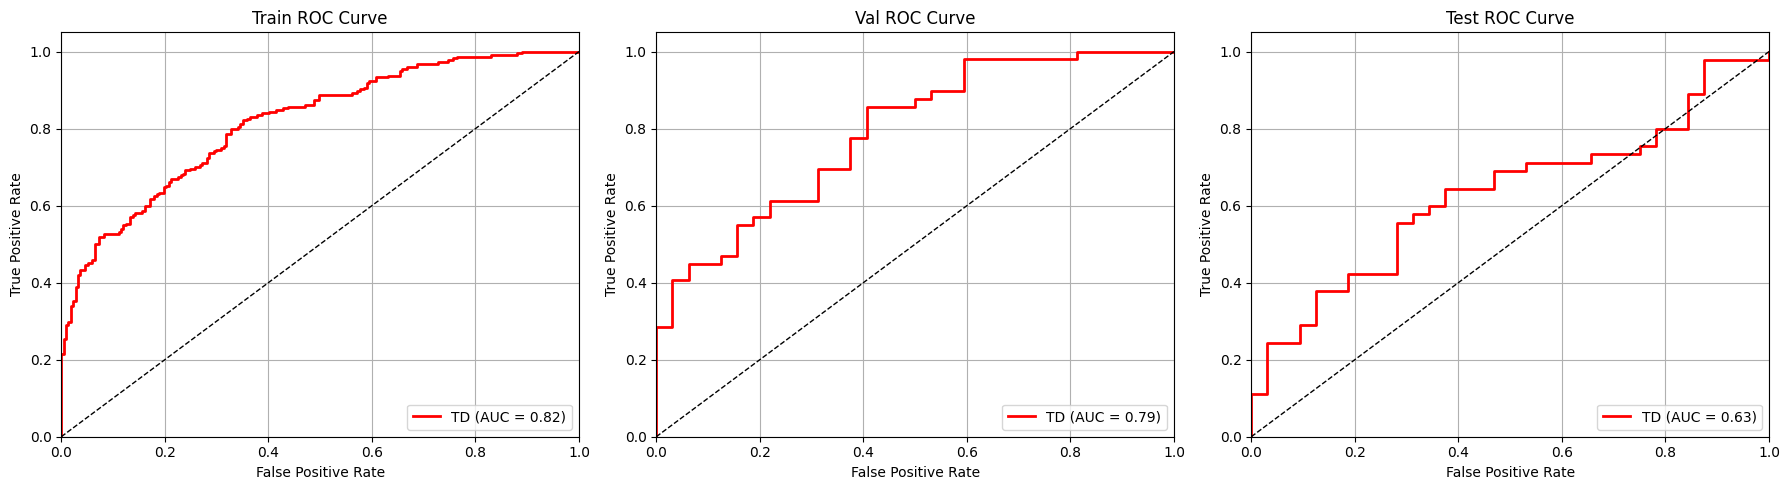

In [13]:
gat_binary_model = GATFLAT(in_ = gat_binary['num_of_features']['value'], 
                            out_ = gat_binary['num_of_classes']['value']-1, 
                            layer_1_out = gat_binary['hidden_channels_1']['value'], 
                            dropout_rate = gat_binary['dropout']['value'], 
                            activation_ = gat_binary['activation']['value'], 
                            heads_ = gat_binary['att_heads']['value'], 
                            norm_ = gat_binary['layer_norm']['value'], 
                            out_func_ = gat_binary['loss_name']['value'], 
                            random_seed = gat_binary['random_seed']['value'])
                            
gat_binary_model.load_state_dict(torch.load("saved_models/GAT_Binary_absolute_value_and_threshold_394.pt", weights_only=True, map_location=torch.device('cpu')))
gat_binary_model.eval()
loss_func = get_loss_function(gat_binary['loss_name']['value'])

roc_curve_data = {}
for n, d in [('train', train_loader),('val', val_loader), ('test', test_loader)]:
    l, f1, y_score, y = make_interference(data = d,
                                            model = gat_binary_model, 
                                            loss_name = gat_binary['loss_name']['value'], 
                                            loss_func = loss_func)
    print(f"{n} loss: {l} f1:{f1}")
    roc_curve_data[n] = [y, y_score]

plot_ruc(roc_curve_data, num_of_classes = 2)